In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df=pd.read_csv('Test_Scenario4.csv')

# Preprocessing

In [3]:
df["DEP_DATE"]=pd.to_datetime(df["DEP_DATE"], format='%d-%m-%Y %H:%M').dt.date
df["DEP_DATE"]=pd.to_datetime(df["DEP_DATE"])
df=df[['DEP_DATE','NET_BOOKINGS']]

In [4]:
new_df=pd.date_range('2017-01-01',periods=1095, freq='D')
date_df=pd.DataFrame(new_df,columns=["Date"])

In [5]:
df_main=date_df.merge(df,how='left', left_on='Date', right_on="DEP_DATE")
df_main.drop(columns=["DEP_DATE"],inplace=True)
df_main.set_index('Date', inplace=True)
df_main.index.freq='D'

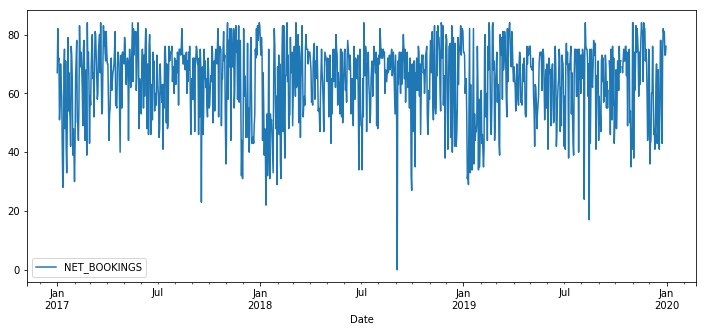

In [6]:
df_main.plot(figsize=(12,5))

In [7]:
df_main.fillna(df_main['NET_BOOKINGS'].mean(), inplace=True)

# Forecast

# Exponential Smoothing

In [8]:
train=df_main[:int(len(df_main)*0.85)]
test=df_main[int(len(df_main)*0.85):]
print(train.shape)
print(test.shape)

(930, 1)
(165, 1)


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fitted_model=ExponentialSmoothing(train['NET_BOOKINGS']).fit()

C:\Users\Rohit\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [10]:
test_prediction_es=fitted_model.forecast(165)

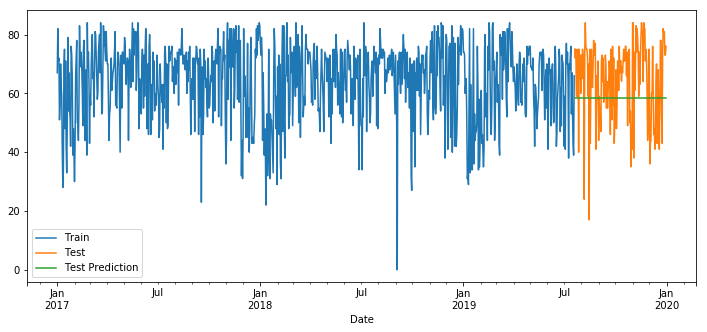

In [11]:
train['NET_BOOKINGS'].plot(legend=True,label='Train',figsize=(12,5))
test['NET_BOOKINGS'].plot(legend=True,label='Test',figsize=(12,5))
test_prediction_es.plot(legend=True,label='Test Prediction',figsize=(12,5))

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
test.describe()

,NET_BOOKINGS
count,165.000000
mean,64.638205
std,13.227337
min,17.000000
25%,56.000000
50%,70.000000
75%,75.000000
max,84.000000


In [14]:
mean_absolute_error(test, test_prediction_es)

12.76597006347649

In [15]:
np.sqrt(mean_squared_error(test, test_prediction_es))

14.587598577558472

# Simple Exponential Smoothing

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
fitted_model=SimpleExpSmoothing(train['NET_BOOKINGS']).fit(smoothing_level=2/(12+1), optimized=False)

C:\Users\Rohit\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [18]:
test_prediction_ses=fitted_model.forecast(165)

In [19]:
mean_absolute_error(test, test_prediction_ses)

12.939421487788803

In [20]:
np.sqrt(mean_squared_error(test, test_prediction_ses))

14.75033171265235

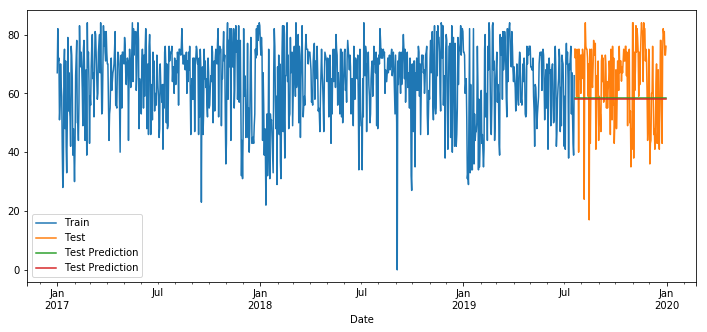

In [21]:
train['NET_BOOKINGS'].plot(legend=True,label='Train',figsize=(12,5))
test['NET_BOOKINGS'].plot(legend=True,label='Test')
test_prediction_es.plot(legend=True,label='Test Prediction')
test_prediction_ses.plot(legend=True,label='Test Prediction')

# ARIMA

In [22]:
from pmdarima import auto_arima

In [23]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

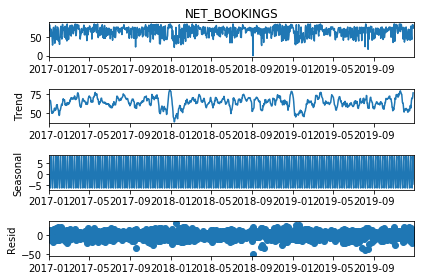

In [25]:
result=seasonal_decompose(df_main["NET_BOOKINGS"])
result.plot();

Lots of Noise. Hence checking for seasoinality using ad-fuller test

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
#help(adfuller)
adfuller(df_main["NET_BOOKINGS"])

(-6.1767043216926885,
 6.603873324844264e-08,
 22,
 1072,
 {'1%': -3.4364647646486093,
  '5%': -2.864239892228526,
  '10%': -2.5682075189699822},
 8299.46670702027)

p-value<0.5, we reject NULL hypothesis. Hence data is stationary

In [28]:
stepwise_fit=auto_arima(df_main["NET_BOOKINGS"], start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12265.533, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9020.994, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11144.401, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8875.908, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8595.863, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8656.305, Time=0.20 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8602.580, Time=0.63 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8583.344, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8581.853, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8596.740, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8580.874,

In [29]:
train=df_main[:int(len(df_main)*0.85)]
test=df_main[int(len(df_main)*0.85):]
print(train.shape)
print(test.shape)

(930, 1)
(165, 1)


In [30]:
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(train["NET_BOOKINGS"], order=(1,0,0))

In [31]:
result=model.fit()

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           NET_BOOKINGS   No. Observations:                  930
Model:                     ARMA(1, 0)   Log Likelihood               -3630.120
Method:                       css-mle   S.D. of innovations             11.993
Date:                Fri, 12 Mar 2021   AIC                           7266.239
Time:                        20:56:23   BIC                           7280.745
Sample:                    01-01-2017   HQIC                          7271.772
                         - 07-19-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 64.0683      0.596    107.476      0.000      62.900      65.237
ar.L1.NET_BOOKINGS     0.3406      0.031     11.057      0.000       0.280       0.401
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9357           +0.0000j            2.9357            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
start=len(train)
end=len(train)+len(test)-1

In [34]:
predictions=result.predict(start, end, typ='levels').rename('ARIMA (1,0,0) Predictions')

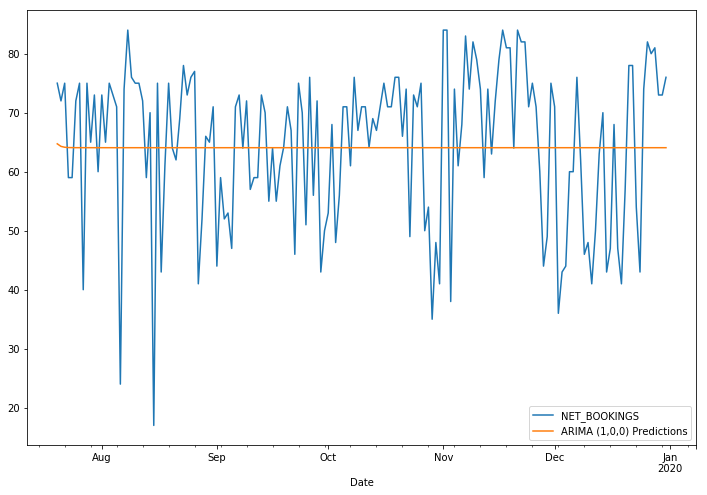

In [35]:
test["NET_BOOKINGS"].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

In [36]:
print("Mean of Test Set:           ",test["NET_BOOKINGS"].mean())
print("Mean of Predicted Test Set: ",predictions.mean())

Mean of Test Set:            64.6382045523857
Mean of Predicted Test Set:  64.07434576323637


# Summary

In [37]:
print("Using Exponential Smoothing")
print("MAE: ",mean_absolute_error(test, test_prediction_es))
print("MSE: ",np.sqrt(mean_squared_error(test, test_prediction_es)))
print("Using Simple Exponential Smoothing")
print("MAE: ",mean_absolute_error(test, test_prediction_ses))
print("MSE: ",np.sqrt(mean_squared_error(test, test_prediction_ses)))
print("Using ARIMA")
print("MAE: ",mean_absolute_error(test, predictions))
print("MSE: ",np.sqrt(mean_squared_error(test, predictions)))

Using Exponential Smoothing
MAE:  12.76597006347649
MSE:  14.587598577558472
Using Simple Exponential Smoothing
MAE:  12.939421487788803
MSE:  14.75033171265235
Using ARIMA
MAE:  10.971266855167189
MSE:  13.195179914662972


# 30 Day Forecast (ARIMA)

In [38]:
model=ARIMA(df_main["NET_BOOKINGS"], order=(1,0,0))

In [39]:
results=model.fit()

In [40]:
forecast=results.predict(start=len(df_main), end=len(df_main)+30).rename('ARIMA(1,0,0) Forecast')

In [41]:
print("Mean of Forecasted Date: ",forecast.mean())
print("Mean of the DatFrame:    ",df_main["NET_BOOKINGS"].mean())

Mean of Forecasted Date:  64.33999945537276
Mean of the DatFrame:     64.15187557182068


# Showing Forecast  + Previous 100 datapoints

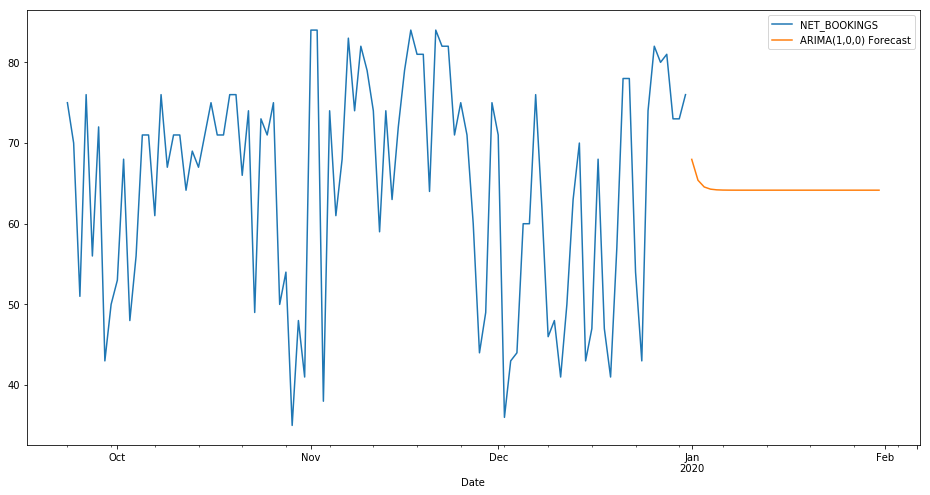

In [42]:
df_main[-100:].plot(figsize=(16,8), legend=True)
forecast.plot(legend=True)

# 30-Day Forecast

In [43]:
pd.DataFrame(forecast)

,"ARIMA(1,0,0) Forecast"
2020-01-01,67.975945
2020-01-02,65.389050
2020-01-03,64.555054
2020-01-04,64.286180
2020-01-05,64.199497
2020-01-06,64.171551
2020-01-07,64.162542
2020-01-08,64.159637
2020-01-09,64.158701
2020-01-10,64.158399
